## Calculations and plots for blog post 

### TR 3990x vs 3970x vs 3265W Performance and  Scaling 

These are typical imports I do for almost any data analysis

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
sns.set() # not using seaborn but this makes the plots look better
%matplotlib inline

- **Performance data**  HPL: GFLOP/s, Numpy norm(A@B): seconds to complete, NAMD: day/ns
- **Scaling data** (job perf in seconds  vs number of CPU cores)

## HPL Linpack Performance

In [72]:
dfhpl = pd.DataFrame({'CPU':[
    'EPYC (2)7742 120-core-Azure BLIS2',
    'TR 3990x 64-core AVX2 BLIS2',
    'TR 3970x 32-Core AVX2 BLIS2',
    'Xeon 3265-W 24-core AVX512 MKL',
    'TR 3960x (24 cores AVX2 BLIS2)',
    'Xeon 2175W (14 cores, AVX512)',
    'i7 9800X (8 cores, AVX512 MKL)',
    'Xeon 2145W (8 cores, AVX512 MKL)',
    'Ryzen 3950X (16 cores AVX2 BLIS2)',
    'TR 2990WX (32 cores AVX2 BLIS1.3)',
    'Ryzen 3900X (12 cores AVX2 BLIS2.0)',
    'i9 9900K (8 cores, AVX2 MKL)'
     ], 
    'GFLOP/s':[2483, 1571,1326,1317,1013,838,771,660,637,597,539,476]})
dfhpl



,CPU,GFLOP/s
0,EPYC (2)7742 120-core-Azure BLIS2,2483
1,TR 3990x 64-core AVX2 BLIS2,1571
2,TR 3970x 32-Core AVX2 BLIS2,1326
3,Xeon 3265-W 24-core AVX512 MKL,1317
4,TR 3960x (24 cores AVX2 BLIS2),1013
5,"Xeon 2175W (14 cores, AVX512)",838
6,"i7 9800X (8 cores, AVX512 MKL)",771
7,"Xeon 2145W (8 cores, AVX512 MKL)",660
8,Ryzen 3950X (16 cores AVX2 BLIS2),637
9,TR 2990WX (32 cores AVX2 BLIS1.3),597


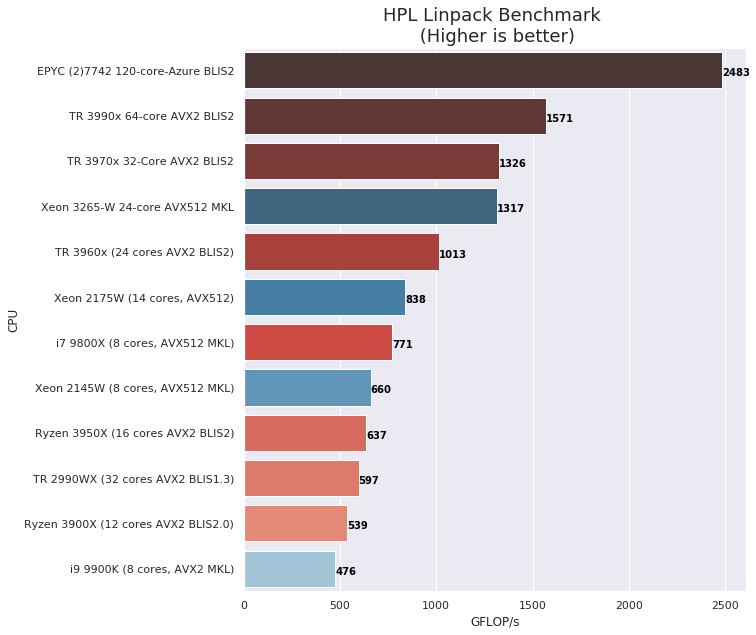

In [73]:
plt.figure(figsize=(9,10))

clrs = sns.color_palette("Reds_d", 12)
clrs2 = sns.color_palette("Blues_d", 12)
#print(clrs)
clrs[3]=clrs2[3]
clrs[5]=clrs2[5]
clrs[7]=clrs2[7]
clrs[11]=clrs2[11]

#clrs[2]=sns.xkcd_rgb["blue"]
#clrs[1]=sns.xkcd_rgb["red"]

ax = sns.barplot(y="CPU", x="GFLOP/s", data=dfhpl, palette=clrs)
#ax.set_xlim(100,320)
ax.set_title('HPL Linpack Benchmark \n (Higher is better)', fontsize=18)

y = dfhpl['GFLOP/s']
for i, v in enumerate(y):
    ax.text(v , i + .125, str(v), color='black', fontweight='bold')

## HPL Performance Scaling

In [17]:
hpl3990 = np.array([12064,6334,3652,1980,1139,861,724,647,619,601,599])
hpl3970 = np.array([12111,6162,3297,1720,1143,1068,951])
#hpl3265 = np.array([9671,4738,2513,1306,853,750])

baseline = hpl3990[0]

hpl3990 = baseline/hpl3990
hpl3970 = baseline/hpl3970
#hpl3265 = baseline/hpl3265

# don't have the data!
#hpl3265 = np.array([102.1,208.5,393.1,756.1,1157.6 1316.8])

In [19]:
numcores = np.array([1,2,4,8,16,24,32,40,48,56,64])

def amdhal3990(n,P):
    return hpl3990[0]/((1-P)+(P/n))
popt3990, pcov = curve_fit(amdhal3990, numcores, hpl3990)

def amdhal3970(n,P):
    return hpl3970[0]/((1-P)+(P/n))
popt3970, pcov = curve_fit(amdhal3970, numcores[:7], hpl3970)


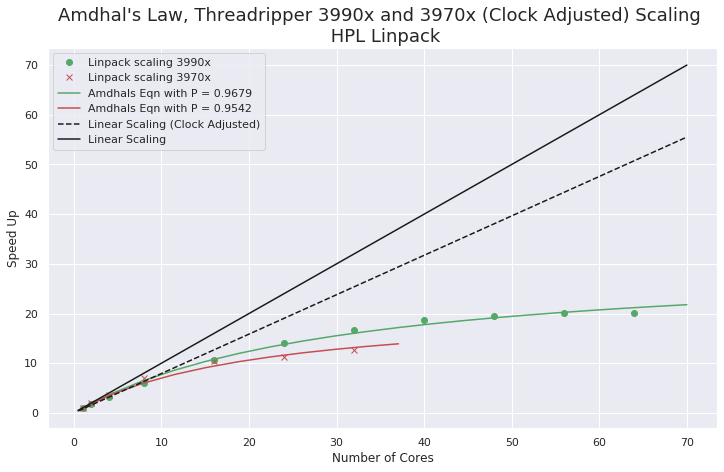

In [26]:
plt.rcParams["figure.figsize"] = [12,7]
#plt.figure(figsize=(16,9))
fig, ax = plt.subplots()
ax.plot( numcores, hpl3990, "o", color='g', label='Linpack scaling 3990x')  # plot the test data
ax.plot( numcores[:7], hpl3970, "x", color='r', label='Linpack scaling 3970x')
#ax.plot( numcores[:6], hpl3265, "d-", color='b', label='Python numpy norm(AxB) scaling 3265W')

xt = np.linspace(0.5,70,20)
ax.plot(xt, amdhal3990(xt,popt3990)  ,color='g',  label='Amdhals Eqn with P = %.4f ' %(popt3990[0]))  # plot the model function
ax.plot(xt[:11], amdhal3970(xt[:11],popt3970)  ,color='r',  label='Amdhals Eqn with P = %.4f ' %(popt3970[0]))
#ax.plot(xt[:8], amdhal3265(xt[:8],popt3265)  ,color='b',  label='Amdhals Eqn with P = %.4f ' %(popt3265[0]))
#ax.plot(xt[:8], amdhal3265mkl(xt[:8],popt3265mkl)  ,color='c',  label='Amdhals Eqn with P = %.4f ' %(popt3265mkl[0]))

slope=3.45/4.35
ax.plot(xt,slope*xt, "--", color='k', label='Linear Scaling (Clock Adjusted)')
ax.plot(xt,1*xt, color='k', label='Linear Scaling')


plt.xlabel("Number of Cores")
plt.ylabel("Speed Up")
plt.title("Amdhal's Law, Threadripper 3990x and 3970x (Clock Adjusted) Scaling \n HPL Linpack", fontsize=18)
ax.legend()

This is Amdhal's Law equation that I will "fit" the data to.

This is the curve fit. Really easy using scipy!  
popt is the optimized parameter P and pcov is the 
covarience which is just a statistics measure that I don't need
but I need a variable for it since it is part of the output from 
that command.

#### This mess generates the plots with matplotlib

## Numpy OpenBLAS and MKL norm(A@B)  3990x, 3970x, 3265W, EPYC 7v12 Performance

In [76]:
dfnorm = pd.DataFrame({'CPU':[
    'EPYC (2)7742 120-core-Azure(96) BLIS2',
    'Xeon 3265W 24-core numpy MKL',
    'TR 3990x 64-core(56) numpy OpenBLAS',
    'TR 3970x 32-Core numpy OpenBLAS',
    'Xeon 3265W 24-core numpy MKL-DEBUG', #MKL_DEBUG_CPU_TYPE=5
    'Xeon 3265W 24-core numpy OpenBLAS'
     ], 
    'Seconds':[9.55, 11.0,11.2, 13.5,16.6,20.5 ]})
dfnorm

,CPU,Seconds
0,EPYC (2)7742 120-core-Azure(96) BLIS2,9.55
1,Xeon 3265W 24-core numpy MKL,11.00
2,TR 3990x 64-core(56) numpy OpenBLAS,11.20
3,TR 3970x 32-Core numpy OpenBLAS,13.50
4,Xeon 3265W 24-core numpy MKL-DEBUG,16.60
5,Xeon 3265W 24-core numpy OpenBLAS,20.50


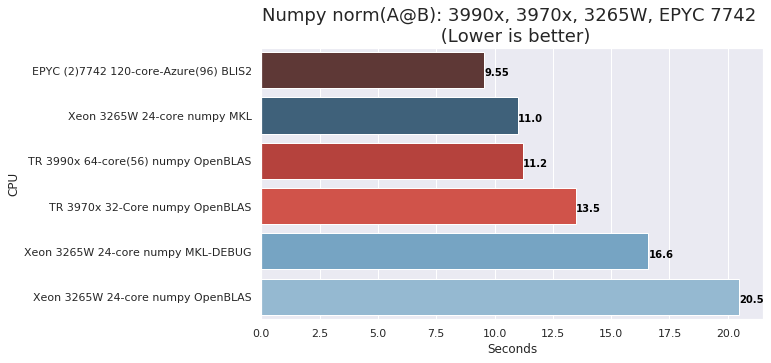

In [77]:
plt.figure(figsize=(9,5))

clrs = sns.color_palette("Reds_d", 6)
clrs2 = sns.color_palette("Blues_d", 6)
#print(clrs)
clrs[1]=clrs2[1]
clrs[4]=clrs2[4]
clrs[5]=clrs2[5]

#print(clrs)
#clrs[1]=sns.xkcd_rgb["red"]
#clrs[2]=sns.xkcd_rgb["red"]
#clrs[3]=sns.xkcd_rgb["red"]

ax = sns.barplot(y="CPU", x="Seconds", data=dfnorm, palette=clrs)
#ax.set_xlim(100,320)
ax.set_title('Numpy norm(A@B): 3990x, 3970x, 3265W, EPYC 7742 \n (Lower is better)', fontsize=18)

y = dfnorm['Seconds']
for i, v in enumerate(y):
    ax.text(v , i + .125, str(v), color='black', fontweight='bold')

## Numpy OpenBLAS norm(A@B) 3990x vs 3970x vs 3265W Scaling 

In [89]:
mnormepyc = np.array([439,222,112,57.7,30.2,15.7,11.7,11.6,11.8,9.55,9.90,10.3])
mnorm3990 = np.array([341,171,86,44,23,17,14,12,11.4,11.2,11.5])
mnorm3970 = np.array([335.9,167.8,84.7,43.3,23.0,16.3,13.5])
mnorm3265 = np.array([354.0,163.8,85.5,43.9,25.0,20.5])
mnorm3265mkl = np.array([171.1,75.6,39.5,20.7,13.2,11.0])
mnorm3265mkldbg = np.array([290.8,147.4,76.8,38.8,21.4,16.8])

baseline = mnorm3265[0]

mnormepyc = baseline/mnormepyc
mnorm3990 = baseline/mnorm3990
mnorm3970 = baseline/mnorm3970
mnorm3265 = baseline/mnorm3265
mnorm3265mkl = baseline/mnorm3265mkl
mnorm3265mkldbg = baseline/mnorm3265mkldbg

numcores = np.array([1,2,4,8,16,24,32,40,48,56,64])
numcores2 = np.array([1,2,4,8,16,32,48,64,80,96,112,120])


In [83]:
def amdhal3990(n,P):
    return mnorm3990[0]/((1-P)+(P/n))
popt3990, pcov = curve_fit(amdhal3990, numcores, mnorm3990)

def amdhal3970(n,P):
    return mnorm3970[0]/((1-P)+(P/n))
popt3970, pcov = curve_fit(amdhal3970, numcores[:7], mnorm3970)

def amdhal3265(n,P):
    return mnorm3265[0]/((1-P)+(P/n))
popt3265, pcov = curve_fit(amdhal3265, numcores[:6], mnorm3265)

def amdhal3265mkl(n,P):
    return mnorm3265mkl[0]/((1-P)+(P/n))
popt3265mkl, pcov = curve_fit(amdhal3265mkl, numcores[:6], mnorm3265mkl)

def amdhal3265mkldbg(n,P):
    return mnorm3265mkldbg[0]/((1-P)+(P/n))
popt3265mkl, pcov = curve_fit(amdhal3265mkldbg, numcores[:6], mnorm3265mkldbg)

popt3990

array([0.98552062])

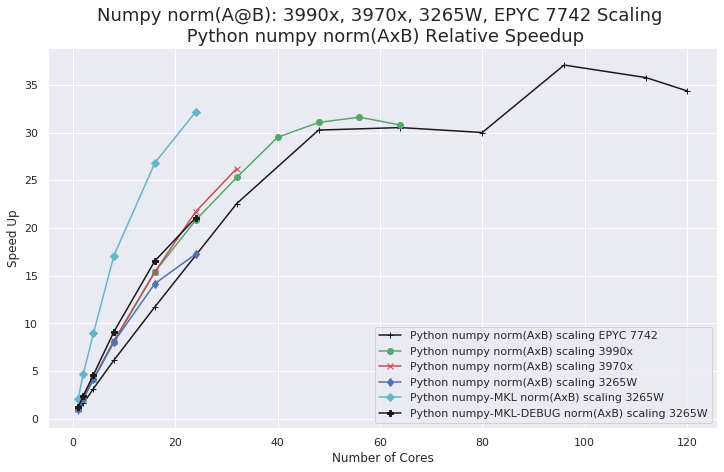

In [90]:
plt.rcParams["figure.figsize"] = [12,7]
#plt.figure(figsize=(16,9))
fig, ax = plt.subplots()
ax.plot( numcores2, mnormepyc, "+-", color='k', label='Python numpy norm(AxB) scaling EPYC 7742')
ax.plot( numcores, mnorm3990, "o-", color='g', label='Python numpy norm(AxB) scaling 3990x')
ax.plot( numcores[:7], mnorm3970, "x-", color='r', label='Python numpy norm(AxB) scaling 3970x')
ax.plot( numcores[:6], mnorm3265, "d-", color='b', label='Python numpy norm(AxB) scaling 3265W')
ax.plot( numcores[:6], mnorm3265mkl, "D-", color='c', label='Python numpy-MKL norm(AxB) scaling 3265W')
ax.plot( numcores[:6], mnorm3265mkldbg, "P-", color='k', label='Python numpy-MKL-DEBUG norm(AxB) scaling 3265W')

#xt = np.linspace(0.5,70,20)
#ax.plot(xt, amdhal3990(xt,popt3990)  ,color='g',  label='Amdhals Eqn with P = %.4f ' %(popt3990[0]))  # plot the model function
#ax.plot(xt[:11], amdhal3970(xt[:11],popt3970)  ,color='r',  label='Amdhals Eqn with P = %.4f ' %(popt3970[0]))
#ax.plot(xt[:8], amdhal3265(xt[:8],popt3265)  ,color='b',  label='Amdhals Eqn with P = %.4f ' %(popt3265[0]))
#ax.plot(xt[:8], amdhal3265mkl(xt[:8],popt3265mkl)  ,color='c',  label='Amdhals Eqn with P = %.4f ' %(popt3265mkl[0]))

#ax.plot(xt,hpl[0]*xt, color='k', label='Linear Scaling')

plt.xlabel("Number of Cores")
plt.ylabel("Speed Up")
plt.title("Numpy norm(A@B): 3990x, 3970x, 3265W, EPYC 7742 Scaling \n Python numpy norm(AxB) Relative Speedup", fontsize=18)
ax.legend()

## HPCG

In [80]:
hpcg3265=[1.65,3.13,5.90,10.8,14.3,14.8]
# 1 2 4 8 16 24
hpcg3990=[2.79,4.68,7.96,9.88,10.2,9.94,9.80,9.65,9.54,9.41,9.30]
# 1 2 4 8 16 24 32 40 4 8 56 64
hpcg3970=[2.68,4.56,8.06,9.93,9.80,9.59,9.38]
# 1 2 4 8 16 24 32
hpcgepyc=[2.14,3.98,7.87,13.1,21.2,28.4,31.5,33.1,34.0,31.7,36.6]
numcores2=[ 1, 2, 4, 8, 16, 32, 48, 64, 80, 96, 120]

In [81]:
dfhpcg = pd.DataFrame({'CPU':[
    'EPYC (2)7742 120-core(120)',
    'Xeon 3265W 24-core(24)',
    'TR 3990x 64-core(16)',
    'TR 3970x 32-Core(8)',
     ], 
    'Seconds':[36.6,14.8,10.2,9.93]})
dfhpcg

,CPU,Seconds
0,EPYC (2)7742 120-core(120),36.60
1,Xeon 3265W 24-core(24),14.80
2,TR 3990x 64-core(16),10.20
3,TR 3970x 32-Core(8),9.93


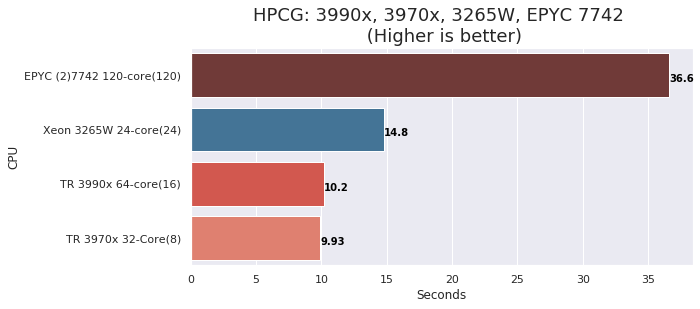

In [82]:
plt.figure(figsize=(9,4))

clrs = sns.color_palette("Reds_d", 4)
clrs2 = sns.color_palette("Blues_d", 4)
#print(clrs)
clrs[1]=clrs2[1]
#clrs[4]=clrs2[4]
#clrs[5]=clrs2[5]

#print(clrs)
#clrs[1]=sns.xkcd_rgb["red"]
#clrs[2]=sns.xkcd_rgb["red"]
#clrs[3]=sns.xkcd_rgb["red"]

ax = sns.barplot(y="CPU", x="Seconds", data=dfhpcg, palette=clrs)
#ax.set_xlim(100,320)
ax.set_title('HPCG: 3990x, 3970x, 3265W, EPYC 7742 \n (Higher is better)', fontsize=18)

y = dfhpcg['Seconds']
for i, v in enumerate(y):
    ax.text(v , i + .125, str(v), color='black', fontweight='bold')

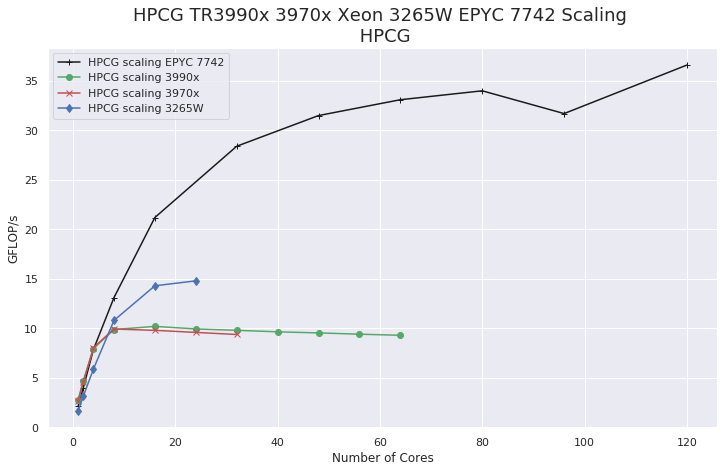

In [83]:
plt.rcParams["figure.figsize"] = [12,7]
#plt.figure(figsize=(16,9))
fig, ax = plt.subplots()
ax.plot( numcores2, hpcgepyc, "+-", color='k', label='HPCG scaling EPYC 7742')
ax.plot( numcores, hpcg3990, "o-", color='g', label='HPCG scaling 3990x')
ax.plot( numcores[:7], hpcg3970, "x-", color='r', label='HPCG scaling 3970x')
ax.plot( numcores[:6], hpcg3265, "d-", color='b', label='HPCG scaling 3265W')

#xt = np.linspace(0.5,70,20)
#ax.plot(xt, amdhal3990(xt,popt3990)  ,color='g',  label='Amdhals Eqn with P = %.4f ' %(popt3990[0]))  # plot the model function
#ax.plot(xt[:11], amdhal3970(xt[:11],popt3970)  ,color='r',  label='Amdhals Eqn with P = %.4f ' %(popt3970[0]))
#ax.plot(xt[:8], amdhal3265(xt[:8],popt3265)  ,color='b',  label='Amdhals Eqn with P = %.4f ' %(popt3265[0]))
#ax.plot(xt[:8], amdhal3265mkl(xt[:8],popt3265mkl)  ,color='c',  label='Amdhals Eqn with P = %.4f ' %(popt3265mkl[0]))

#ax.plot(xt,hpl[0]*xt, color='k', label='Linear Scaling')

plt.xlabel("Number of Cores")
plt.ylabel("GFLOP/s")
plt.title("HPCG TR3990x 3970x Xeon 3265W EPYC 7742 Scaling \n HPCG", fontsize=18)
ax.legend()

## NAMD ApoA1  3990x vs 3970x Performance

In [84]:
dfapoa1 = pd.DataFrame({'CPU':[
    'TR 3990x 64-core + (2)NVIDIA RTX Titan',
    'TR 3970x 32-Core + (2)NVIDIA RTX 2080Ti',
    'EPYC (2)7742 120-core(120)',
    'TR 3990x 64-core + 64-SMT',
    'TR 3970x 32-Core + 32-SMT',
    'Xeon 3265W 24-core + 24-HT',
    'Xeon 3265W 24-core(24) No-HT',
     ], 
    'day/ns':[ 0.0201,0.01933,0.101,0.1325,0.1874,0.270,0.319]})
dfapoa1

,CPU,day/ns
0,TR 3990x 64-core + (2)NVIDIA RTX Titan,0.02010
1,TR 3970x 32-Core + (2)NVIDIA RTX 2080Ti,0.01933
2,EPYC (2)7742 120-core(120),0.10100
3,TR 3990x 64-core + 64-SMT,0.13250
4,TR 3970x 32-Core + 32-SMT,0.18740
5,Xeon 3265W 24-core + 24-HT,0.27000
6,Xeon 3265W 24-core(24) No-HT,0.31900


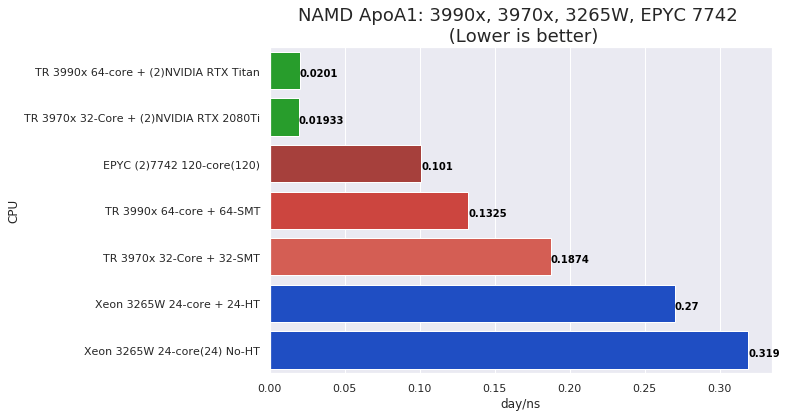

In [85]:
plt.figure(figsize=(9,6))

clrs = sns.color_palette("Reds_d", 7)
#print(clrs)
clrs[0]=sns.xkcd_rgb["green"]
clrs[1]=sns.xkcd_rgb["green"]
clrs[5]=sns.xkcd_rgb["blue"]
clrs[6]=sns.xkcd_rgb["blue"]

ax = sns.barplot(y="CPU", x="day/ns", data=dfapoa1, palette=clrs)
#ax.set_xlim(100,320)
ax.set_title('NAMD ApoA1: 3990x, 3970x, 3265W, EPYC 7742 \n (Lower is better)', fontsize=18)

y = dfapoa1['day/ns']
for i, v in enumerate(y):
    ax.text(v , i + .125, str(v), color='black', fontweight='bold')

## NAMD ApoA1  3990x vs 3970x Scaling

In [61]:
apoa1 = np.array([267,136,70,37,20,14,11.3,9.7,8.2,7.7,7.5])
apoa1 = apoa1[0]/apoa1
numcores = np.array([1,2,4,8,16,24,32,40,48,56,64])
apoa1

array([ 1.        ,  1.96323529,  3.81428571,  7.21621622, 13.35      ,
       19.07142857, 23.62831858, 27.5257732 , 32.56097561, 34.67532468,
       35.6       ])

In [62]:
def amdhal(n,P):
    return apoa1[0]/((1-P)+(P/n))

popt, pcov = curve_fit(amdhal, numcores, apoa1)
popt

array([0.98842866])

In [63]:
# data for 3970x 32 core
apoa132 = np.array([261.0,132.6,68.9,36.0,19.1,13.3,10.8])
apoa132 = apoa132[0]/apoa132
print(apoa132)

def amdhal32(n,P):
    return apoa132[0]/((1-P)+(P/n))
popt32, pcov32 = curve_fit(amdhal32, numcores[:7], apoa132)
popt32

[ 1.          1.96832579  3.78809869  7.25       13.66492147 19.62406015
 24.16666667]


array([0.9896649])

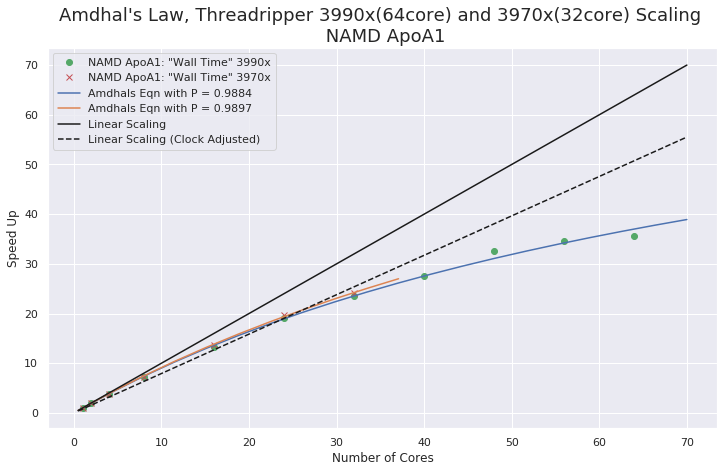

In [65]:
plt.rcParams["figure.figsize"] = [12,7]
#plt.figure(figsize=(16,9))
fig, ax = plt.subplots()
ax.plot( numcores, apoa1, "o", color='g', label='NAMD ApoA1: "Wall Time" 3990x')  # plot the test data
ax.plot( numcores[:7], apoa132, "x", color='r', label='NAMD ApoA1: "Wall Time" 3970x')

xt = np.linspace(0.5,70,20)
ax.plot(xt, amdhal(xt,popt)  ,  label='Amdhals Eqn with P = %.4f ' %(popt[0]))  # plot the model function
ax.plot(xt[:11], amdhal32(xt[:11],popt32)  ,  label='Amdhals Eqn with P = %.4f ' %(popt32[0]))

ax.plot(xt,xt, color='k', label='Linear Scaling')
slope=3.45/4.35
ax.plot(xt,slope*xt, "--", color='k', label='Linear Scaling (Clock Adjusted)')

plt.xlabel("Number of Cores")
plt.ylabel("Speed Up")
plt.title("Amdhal's Law, Threadripper 3990x(64core) and 3970x(32core) Scaling \n NAMD ApoA1", fontsize=18)
ax.legend()

In [63]:
1/(1-popt)

array([86.42043539])

## NAMD STMV  3990x vs 3970x Performance

In [86]:
dfstmv = pd.DataFrame({'CPU':[
    'Xeon 3265W 24-core + (4)NVIDIA RTX 2080Ti',
    'TR 3990x 64-core + (2)NVIDIA RTX Titan',
    'TR 3970x 32-Core + (2)NVIDIA RTX 2080Ti',
    'EPYC (2)7742 120-core(120)',
    'TR 3990x 64-core + 64-SMT',
    'TR 3970x 32-Core + 32-SMT',
    'Xeon 3265W 24-core + 24-HT',
    'Xeon 3265W 24-core(24) No-HT',
     ], 
    'day/ns':[ 0.2362, 0.3061,0.3511,1.016,1.601,2.124, 3.13, 3.702]})
dfstmv

,CPU,day/ns
0,Xeon 3265W 24-core + (4)NVIDIA RTX 2080Ti,0.2362
1,TR 3990x 64-core + (2)NVIDIA RTX Titan,0.3061
2,TR 3970x 32-Core + (2)NVIDIA RTX 2080Ti,0.3511
3,EPYC (2)7742 120-core(120),1.0160
4,TR 3990x 64-core + 64-SMT,1.6010
5,TR 3970x 32-Core + 32-SMT,2.1240
6,Xeon 3265W 24-core + 24-HT,3.1300
7,Xeon 3265W 24-core(24) No-HT,3.7020


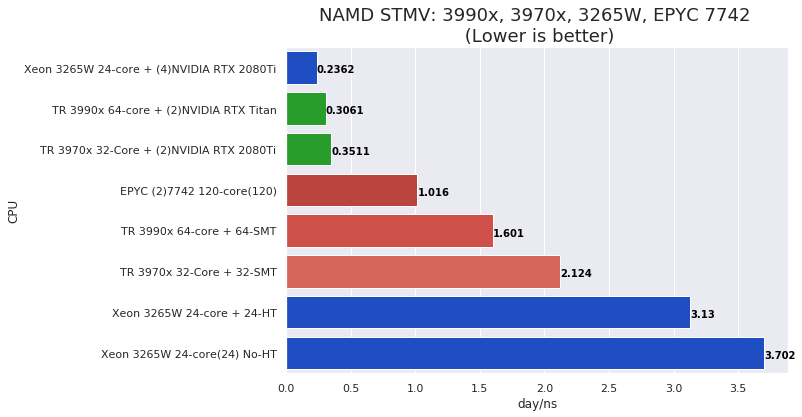

In [87]:
plt.figure(figsize=(9,6))

clrs = sns.color_palette("Reds_d", 8)
#print(clrs)
clrs[0]=sns.xkcd_rgb["blue"]
clrs[1]=sns.xkcd_rgb["green"]
clrs[2]=sns.xkcd_rgb["green"]
clrs[6]=sns.xkcd_rgb["blue"]
clrs[7]=sns.xkcd_rgb["blue"]

ax = sns.barplot(y="CPU", x="day/ns", data=dfstmv, palette=clrs)
#ax.set_xlim(100,320)
ax.set_title('NAMD STMV: 3990x, 3970x, 3265W, EPYC 7742 \n (Lower is better)', fontsize=18)

y = dfstmv['day/ns']
for i, v in enumerate(y):
    ax.text(v , i + .125, str(v), color='black', fontweight='bold')

## NAMD STMV  3990x vs 3970x Scaling

In [76]:
stmv = np.array([2934,1478,763,398,212,148,120,103,92,85,79])
stmv = stmv[0]/stmv
numcores = np.array([1,2,4,8,16,24,32,40,48,56,64])
stmv

array([ 1.        ,  1.98511502,  3.84534731,  7.3718593 , 13.83962264,
       19.82432432, 24.45      , 28.48543689, 31.89130435, 34.51764706,
       37.13924051])

In [77]:
def amdhal(n,P):
    return stmv[0]/((1-P)+(P/n))

popt, pcov = curve_fit(amdhal, numcores, stmv)
popt

array([0.9889665])

In [78]:
# data for 3970x 32 core
stmv32 = np.array([2846,1440,744,387.5,204.6,144.5,114.2])
stmv32 = stmv32[0]/stmv32
print(stmv32)

def amdhal32(n,P):
    return stmv32[0]/((1-P)+(P/n))
popt32, pcov32 = curve_fit(amdhal32, numcores[:7], stmv32)
popt32

[ 1.          1.97638889  3.82526882  7.34451613 13.91006843 19.69550173
 24.92119089]


array([0.99067684])

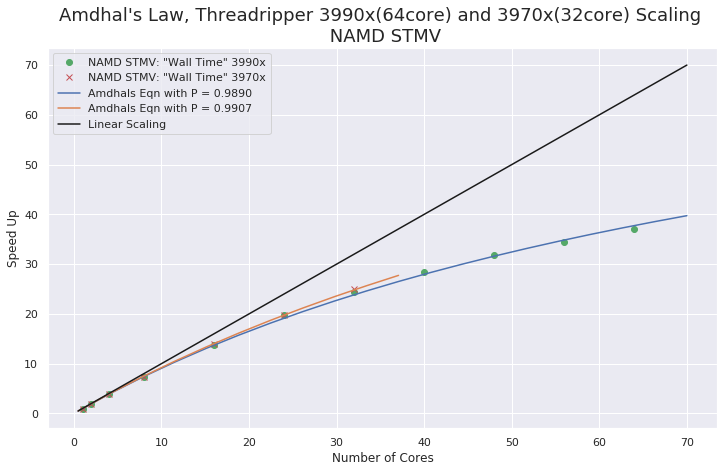

In [81]:
plt.rcParams["figure.figsize"] = [12,7]
#plt.figure(figsize=(16,9))
fig, ax = plt.subplots()
ax.plot( numcores, stmv, "o", color='g', label='NAMD STMV: "Wall Time" 3990x')  # plot the test data
ax.plot( numcores[:7], stmv32, "x", color='r', label='NAMD STMV: "Wall Time" 3970x')

xt = np.linspace(0.5,70,20)
ax.plot(xt, amdhal(xt,popt)  ,  label='Amdhals Eqn with P = %.4f ' %(popt[0]))  # plot the model function
ax.plot(xt[:11], amdhal32(xt[:11],popt32)  ,  label='Amdhals Eqn with P = %.4f ' %(popt32[0]))

ax.plot(xt,hpl[0]*xt, color='k', label='Linear Scaling')

plt.xlabel("Number of Cores")
plt.ylabel("Speed Up")
plt.title("Amdhal's Law, Threadripper 3990x(64core) and 3970x(32core) Scaling \n NAMD STMV", fontsize=18)
ax.legend()